<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import re
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
#Посмотрим сколько у нас токсичных/нектоксичных текстов
display(toxic_comments['toxic'].value_counts())
#Выведем соотношение
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Вывод

Видим что классы несбалансированы, применем несколько спомобов балансировки и сравним их

In [ ]:
#lemmatizer = WordNetLemmatizer()

#def lemmatize_text(text):
#    text = text.lower()
#    lemm_text = "".join(lemmatizer.lemmatize(text))
#    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)
#    return " ".join(cleared_text.split())

#toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)

#toxic_comments = toxic_comments.drop(['text'], axis=1)

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import re
import pandas as pd
from tqdm.notebook import tqdm

# Скачиваем необходимые ресурсы NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

tqdm.pandas()

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для преобразования POS-тегов NLTK в формат WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # по умолчанию считаем существительным

def lemmatize_text(text):
    # Приводим к нижнему регистру
    text = text.lower()

    # Токенизируем текст и получаем POS-теги
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Лемматизируем каждое слово с учетом POS-тега
    lemmatized_tokens = []
    for word, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, wn_tag)
        lemmatized_tokens.append(lemma)

    # Объединяем обратно в текст
    lemm_text = ' '.join(lemmatized_tokens)

    # Удаляем всё, кроме букв
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)

    # Удаляем лишние пробелы
    return " ".join(cleared_text.split())

# Тестируем на небольшом датасете
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns=['text'])
print("Original:")
print(df_my)

print("\nLemmatized:")
df_my['lemm_text'] = df_my['text'].progress_apply(lemmatize_text)
print(df_my)

# Применяем к основному датасету (если тест прошел успешно)
toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(lemmatize_text)
toxic_comments = toxic_comments.drop(['text'], axis=1)

Original:
                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked

Lemmatized:


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  0%|          | 0/2 [00:00<?, ?it/s]

                                                text  \
0  The striped bats are hanging on their feet for...   
1      you should be ashamed of yourself went worked   

                                        lemm_text  
0  the striped bat be hang on their foot for best  
1       you should be ashamed of yourself go work  


  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:

target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

# Первый split: 50% train, 50% временные данные
features_train, features_temp, target_train, target_temp = train_test_split(
    features,
    target,
    test_size=0.5,
    random_state=1515,
    stratify=target
)

# Второй split: 40% от временных данных = 20% от исходных (valid/test)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp,
    target_temp,
    test_size=0.4,
    random_state=1515,
    stratify=target_temp
)

# Загрузка стоп-слов (только при первом запуске)
nltk.download('stopwords', quiet=True)
stopwords = set(nltk_stopwords.words('english'))

# Оптимизированный TF-IDF векторизатор для латинского текста
count_tf_idf = TfidfVectorizer(
    stop_words=stopwords,
    ngram_range=(1, 2),  # Биграммы
    min_df=5,            # Игнорировать очень редкие слова
    max_df=0.7,          # Игнорировать слишком частые (возможно, шум)
    dtype=np.float32
)

# Векторизация БЕЗ преобразования в Unicode (оптимизация для латиницы)
features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
features_valid = count_tf_idf.transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])

# Проверка размеров
print("Размеры данных:")
print(f"Train: {features_train.shape}")
print(f"Valid: {features_valid.shape}")
print(f"Test: {features_test.shape}")

# Проверка распределения классов
print("\nРаспределение классов (toxic/non-toxic):")
print(f"Original: {target.mean():.2%} toxic")
print(f"Train:    {target_train.mean():.2%} toxic")
print(f"Valid:    {target_valid.mean():.2%} toxic")
print(f"Test:     {target_test.mean():.2%} toxic")


cv_counts = 3

Размеры данных:
Train: (79646, 76037)
Valid: (47787, 76037)
Test: (31859, 76037)

Распределение классов (toxic/non-toxic):
Original: 10.16% toxic
Train:    10.16% toxic
Valid:    10.16% toxic
Test:     10.16% toxic


In [ ]:

classificator = LogisticRegression(
    random_state=1515
)
train_f1 = cross_val_score(classificator,
                      features_train,
                      target_train,
                      cv=cv_counts,
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6555880691023165


Балансировка данных

Уменьшение размера весов классов

In [ ]:
dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(random_state=1515,class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7493689251935395


In [ ]:
classificator = LogisticRegression(random_state=1515, class_weight='balanced')
train_f1_balanced = cross_val_score(classificator,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7493689251935395


Ресемплинг с уменшением класса 0

In [ ]:

toxic_comments_train = toxic_comments.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [ ]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))

In [ ]:
classificator = LogisticRegression(random_state=1515,
    class_weight=dict_classes)
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample,
                      target_train_downsample,
                      cv=cv_counts,
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8061407698840505


Видим значительный прирост f1 меры

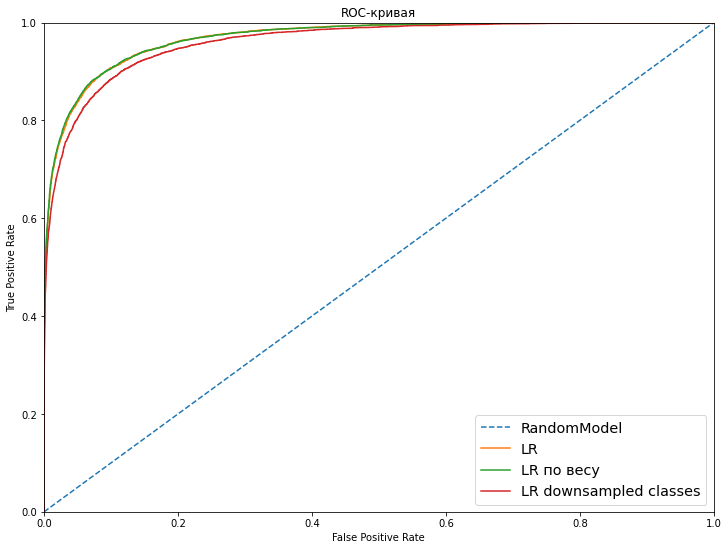

In [ ]:
# Построим ROC-AUC графики балансировки
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression(random_state=1515, class_weight='balanced')
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR по весу')

classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [ ]:
# Построим таблицу результатов баллансировки
index = ['LogisticRegression',
         'LR по весу',
         'LR downsampled classes']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.655588,0.740114,0.968601
LR по весу,0.741528,0.750821,0.968983
LR downsampled classes,0.806141,0.685194,0.960563


Вывод

В ходе подготовки данных мы получили признаки для обучения, получили обучающую, валидационную и тестовую выборку.

По итогу балансировки даееых мо поняли что баланс по весам самый оптимальный, с ним и работаем дальше

## Обучение

Классификатор LogisticRegression

In [ ]:
classificator = LogisticRegression(random_state=1515
    )
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}

Grid scores on development set:

0.706749 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.706781 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.706588 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.749369 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.749369 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.749325 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.753687 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.753640 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.753687 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver

In [ ]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7536869123567885
F1 на валидации 0.7651964231889882


Классификатор DecisionTreeClassifier

In [ ]:
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[1515],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 96, 'random_state': 1515}

Grid scores on development set:

0.610171 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 50, 'random_state': 1515}
0.612242 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 52, 'random_state': 1515}
0.611910 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 54, 'random_state': 1515}
0.610590 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 56, 'random_state': 1515}
0.615743 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 58, 'random_state': 1515}
0.619625 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 60, 'random_state': 1515}
0.622884 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 62, 'random_state': 1515}
0.625086 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 64, 'random_state': 1515}
0

In [ ]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6309913182131581
F1 на валидации 0.6408677807094695


Классификатор CatBoostClassifier

In [ ]:
classificator = CatBoostClassifier(verbose=False, iterations=250)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train,
                                         target_train,
                                         cv=cv_counts,
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7160737690611415
F1 на валидации 0.7337988484625751


In [ ]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.753687,0.765196,True
DecisionTreeClassifier,0.630991,0.640868,False
CatBoostClassifier,0.716074,0.733799,False


Вывод

К тестовому набору данных перейдут LogisticRegression

## Выводы

Метрики LogisticRegression
ROC AUC: 0.9595026310689887
F1: 0.7554821267647943
Precision: 0.7351651563870213
Recall: 0.776953969725054
Accuracy: 0.948899839919646



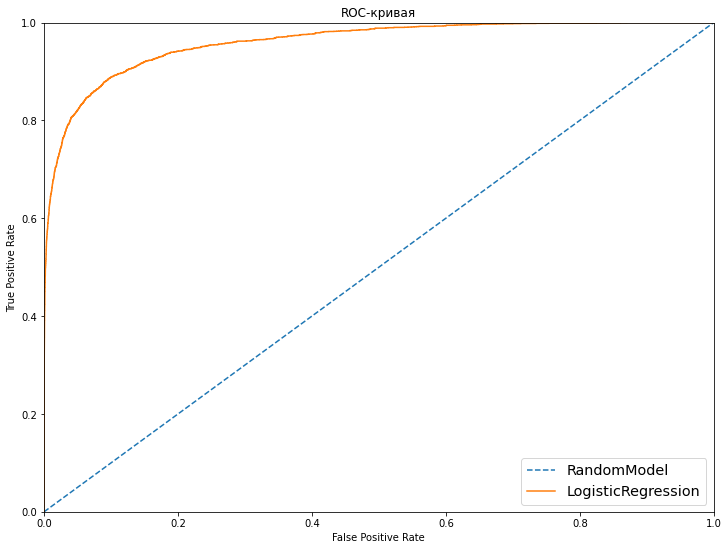

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression(random_state=1515)
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

# Вывод

Было проделано:

Подготовленны данные обучения.

Выбран способ баланса классов, сформированы обучающая, валидационная и тестовая выборка.

Обучены модели и выбрана лучшая из них на валидационной выборке.

Показаны параметры качества моделей.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Лучшая модель стала LogisticRegression.

CatBoostClassifier может показать себя очень хорошо при долгом обучении на данных.